# Tracking the divergence of the gradients

As the weights are adjusted, the jacobian of the function changes. This will prevent continual learning in the Neural Tangent Ensemble. This notebook will track the divergence of the gradients of the function as the weights are adjusted.

In [1]:
import torch
from torchvision import transforms, datasets
from matplotlib import pyplot as plt
import numpy as np
from torch import nn
import torch.optim as optim
import torch.nn.functional as F

import copy
from tqdm import tqdm


In [2]:
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "0"

In [3]:
## Create the problem

def shuffled_MNIST(batch_size, dataset_folder='./data'):
    """Create a MNIST dataset in which pixels are shuffled, and return the test and train dataloaders.
    Uses a new random seed every time it's called.

    Arguments:    batch_size: tha batch size
                  dataself_folder: path to the mnist dataset, or where it should go once downloaded

    """

    kwargs = {'num_workers': 0, 'pin_memory': True}

    permute_mask = torch.randperm(784)

    transform = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.1307,), (0.3081,)),
        transforms.Lambda(lambda x: x.view(784)[permute_mask])
        ])

    train_loader = torch.utils.data.DataLoader(
        datasets.MNIST(dataset_folder, train=True, download=True,
                       transform=transform),
        batch_size=batch_size, shuffle=True, drop_last=True, **kwargs)

    test_loader = torch.utils.data.DataLoader(
        datasets.MNIST(dataset_folder, train=False, transform=transform),
        batch_size=batch_size, shuffle=False, drop_last=True, **kwargs)

    return (train_loader, test_loader)

train_loader, test_loader = shuffled_MNIST(128)
for a,b in train_loader:
  print(a.shape, b.shape)
  break

torch.Size([128, 784]) torch.Size([128])


In [4]:

class MLP(nn.Module):
    def __init__(self, input_dim, output_dim, num_features, n_layers=2):
        super(MLP, self).__init__()
        self.num_features = num_features

        # Initialize the fixed random weights for the first layer
        self.first_layer_weights = nn.Linear(input_dim, num_features)

        # mid layers
        self.mid_layers = nn.ModuleList([nn.Linear(num_features, num_features) for _ in range(n_layers-2)])

        # The second layer is learnable
        self.linear = nn.Linear(num_features, output_dim)

        self.linear.bias.data.fill_(0)
 

    def forward(self, x, ):
        x = self.first_layer_weights(x)
        x = torch.relu(x)

        for layer in self.mid_layers:
            x = layer(x)
            x = torch.relu(x)
        
        output = self.linear(x)

        return output
def count_zero_edges(model):
    zero_edges = 0
    total_edges = 0
    for p in model.parameters():
        zero_edges += (p == 0).sum().item()
        total_edges += p.numel()
    return zero_edges, total_edges



def number_equal_edges(model_params, init_model_params):
    edges = 0
    for p, p_2 in zip(model_params, init_model_params):
        edges += (p==p_2).sum().item()
    return edges

def count_total_edges(model):
    edges = 0
    for p in model.parameters():
        edges += p.numel()
    return edges


test = MLP(784,10,100)
test(torch.rand(128,784)).shape
count_zero_edges(test)


(11, 79510)

In [5]:
from tqdm import tqdm
def train_and_evaluate(model, train_loader, test_loaders, optimizer, num_epochs, device, eval_interval, test_batches=10,log_edges=False):
    model.to(device)  # Move the model to the appropriate device
    all_accuracies = {i: [] for i in range(len(test_loaders))}  # Dictionary to store accuracies
    total_edges = count_total_edges(model)
    batch_count = 0  # Counter for tracking the number of batches
    accuracy = 0
    for epoch in range(num_epochs):
        model.train()
        with tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs}") as t:
            for data, target in t:
                data, target = data.to(device), target.to(device)  # Move data to the appropriate device
                optimizer.zero_grad()
                output = model(data)
                loss = nn.CrossEntropyLoss()(output, target)
                loss.backward()
                if isinstance(optimizer, NTKPoE) or isinstance(optimizer, NTKBayesEnsemble):
                    optimizer.step(loss=loss)
                else:
                    optimizer.step()
                batch_count += 1

                if batch_count % eval_interval == 0:
                    model.eval()
                    with torch.no_grad():
                        for i, test_loader in enumerate(test_loaders):
                            correct = 0
                            total = 0
                            j = 0
                            for data, target in test_loader:
                                data, target = data.to(device), target.to(device)
                                output = model(data)
                                _, predicted = torch.max(output.data, 1)
                                total += target.size(0)
                                correct += (predicted == target).sum().item()
                                j += 1
                                if j >= test_batches:
                                    break
                            accuracy = 100 * correct / total
                            all_accuracies[i].append(accuracy)
                    model.train()

                n_zero_edges = number_equal_edges(model.parameters(), optimizer.init_param_groups_fn()[0]['params']) if log_edges else 0
                t.set_description(f"Epoch {epoch+1}/{num_epochs} - Loss: {loss.item():.4f} - Restored edges: {n_zero_edges} / {total_edges} - Test accuracy: {accuracy:.2f}%")

    return all_accuracies

def plot_accuracies(all_accuracies, num_epochs, num_rounds, eval_interval, train_loader):
    offset = len(train_loader) // eval_interval * num_epochs

    plt.figure(figsize=(10, 6))
    for i, accs in enumerate(all_accuracies):
        accs = np.concatenate([[0]*(i*offset+1)]+[a.get(i,[]) for a in all_accuracies])

        plt.plot(accs, label=f'Task {i+1}')
        plt.vlines(range(0,num_rounds*offset, offset), 0, 100, linestyles=":", colors="r")
    plt.xlabel('Epoch')
    plt.ylabel('Test accuracy on Task (%)')
    plt.title('Accuracy on All Tasks During Continual Learning')
    plt.legend()
    plt.show()

def plot_posteriors(log_posteriors):
    fig, axs = plt.subplots(1, 4, figsize=(15, 3))
    for i, p in enumerate(log_posteriors.items()):
        axs[i].hist(p[1].flatten().cpu().numpy(), bins=100, label=p[0])
        axs[i].set_yscale('log')
        axs[i].set_title(p[0])
    plt.show()

Trying to use the current losses instead of init losses:

In [6]:

def train_and_evaluate_NTKBayes(model, log_posterior_buffer, train_loader, test_loaders, num_epochs, device, init_model=None, 
                    temperature=1, prune_cutoff=100, epsilon=1e-9, test_batches = 10):
    """
    """
    all_accuracies = {i: [] for i in range(len(test_loaders))}  # Dictionary to store accuracies

    loss_fn = nn.CrossEntropyLoss()

    def compute_loss(params, buffers, sample, target):
        batch = sample.unsqueeze(0)
        targets = target.unsqueeze(0)

        predictions = torch.func.functional_call(model, (params, buffers), (batch,))
        loss = loss_fn(predictions, targets)
        return loss

    ft_compute_grad = torch.func.grad_and_value(compute_loss)
    ft_compute_sample_grad = torch.func.vmap(ft_compute_grad, in_dims=(None, None, 0, 0))
    ft_compute_losses = torch.func.vmap(compute_loss, in_dims=(None, None, 0, 0))

    if init_model is None:
        raise #Waiting to implement the zero init case
        init_model_params = {name: 0 for name, p in model.named_parameters()}
        init_model_buffers = {name: 0 for name, p in model.named_buffers()}
    else:
        init_model_params = {k: v.detach() for k, v in init_model.named_parameters()}
        init_model_buffers = {k: v.detach() for k, v in init_model.named_buffers()}

    z = sum([(p-p_c).abs().sum() for ((_, p), (_, p_c)) in zip( model.named_parameters(), init_model_params.items())])
    log_z = torch.log(z)

    frac_parameters = torch.Tensor([p.numel() for (_,p) in model.named_parameters()]).to(device)
    frac_parameters /= frac_parameters.sum()


    batch_count = 0
    accuracy = 0
    cosine_grads = []
    for epoch in range(num_epochs):
        model.train()
        with tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs}") as t:
            for batch, (data, target) in enumerate(t):
                data, target = data.to(device), target.to(device)  # Move data to the appropriate device

                params = {k: v.detach() for k, v in model.named_parameters()}
                buffers = {k: v.detach() for k, v in model.named_buffers()}

                per_example_grad_dict_init, losses_init = ft_compute_sample_grad( init_model_params, init_model_buffers, data, target)
                per_example_grad_dict, losses = ft_compute_sample_grad( params, buffers, data, target)

                # cosine of angle between gradients
                cosines = []
                for (name, d_p), (name2, p) in zip(per_example_grad_dict.items(), per_example_grad_dict_init.items()):
                    cosine = (d_p * p).sum() / (d_p.norm() * p.norm())
                    cosines.append(cosine)
                cosine_grads.append((torch.stack(cosines) @ frac_parameters).item())

                with torch.no_grad():
                    for (name, d_p), (name2, p), (name3, p_c), (_,log_posterior) in zip(per_example_grad_dict.items(), 
                                                                                model.named_parameters(),
                                                                                init_model_params.items(),
                                                                                log_posteriors.items()):
                        if not p.requires_grad:
                            continue

                        if init_model is None:
                            # If init_params is None, use the current gradients divided by 2 for linearization
                            delta_p = p.data
                            d_p = d_p / 2
                        else:
                            # Compute ∆W and use it as the weight for NTK features
                            delta_p = p.data - p_c.data

                        # store sign of weight
                        sign_delta_p = torch.sign(delta_p)

                        n_dims = len(delta_p.size())

                        arg = -sign_delta_p[None] * d_p * z * temperature
                        assert torch.all(arg+1 >= 0), f"Tried log(1+{torch.min(arg).item()}) for {name}. Decrease temperature or ∆W. z is {z.item()}"
                        data_log_likelihood = torch.log1p(arg)
                        data_log_likelihood = data_log_likelihood.sum(dim=0)
                    
                        # Update log(∆W) based on the gradient and temperature
                        log_posterior += data_log_likelihood

                    # Get the log partition function
                    log_z_prime = torch.logsumexp(torch.stack([torch.logsumexp(lp, dim=list(range(len(lp.size()))))
                                                             for (name, lp) in log_posteriors.items()]), dim=0)

                    # set parameters
                    for (name, log_posterior), (_, p), (_, p_c) in zip(log_posteriors.items(), model.named_parameters(), init_model_params.items()):
                        if not p.requires_grad:
                            continue

                        log_posterior += log_z - log_z_prime
                        sign_delta_p = torch.sign(p.data - p_c.data)

                        # Warn if any log_posterior is too small
                        if torch.any(log_posterior <= torch.finfo(log_posterior.dtype).min):
                            print(f"WARNING: {name} has reached the minimum value of {torch.finfo(log_posterior.dtype).min}. Consider decreasing the temperature.")

                        # Update the parameter.
                        if init_model is None:
                            raise #Waiting to implement the zero init case
                        else:
                            p.data = p_c.data + sign_delta_p * torch.clamp(torch.exp(log_posterior),max=prune_cutoff)

                    if batch_count % eval_interval == 0:
                        model.eval()
                        for i, test_loader in enumerate(test_loaders):
                            correct = 0
                            total = 0
                            j = 0
                            for data, target in test_loader:
                                data, target = data.to(device), target.to(device)
                                output = model(data)
                                loss =  nn.CrossEntropyLoss()(output, target)
                                _, predicted = torch.max(output.data, 1)
                                total += target.size(0)
                                correct += (predicted == target).sum().item()
                                j += 1
                                if j >= test_batches:
                                    break
                            accuracy = 100 * correct / total
                            all_accuracies[i].append(accuracy)
                        model.train()

                    batch_count += 1

                t.set_description(f"Epoch {epoch+1}/{num_epochs} - Loss: {losses.mean().item():.4f}  - Test accuracy: {accuracy:.2f}%") #t.set_description
                
    return all_accuracies, cosine_grads

def perturb_model(model, noise_scale):
    for p in model.parameters():
        p.data += torch.randn_like(p.data) * noise_scale
    return model

def perturb_model_bernoulli(model, noise_scale):
    for p in model.parameters():
        p.data += torch.sign(torch.randn_like(p.data)) * noise_scale
    return model


Epoch 1/1 - Loss: 0.1945  - Test accuracy: 97.92%: 100%|██████████| 2500/2500 [12:42<00:00,  3.28it/s]


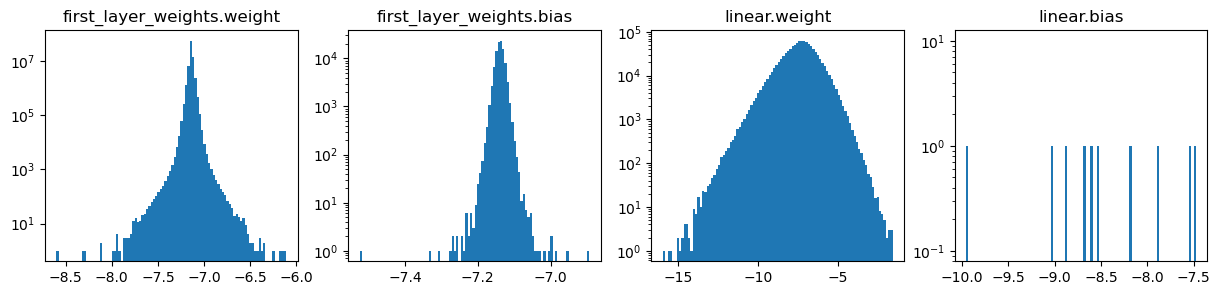

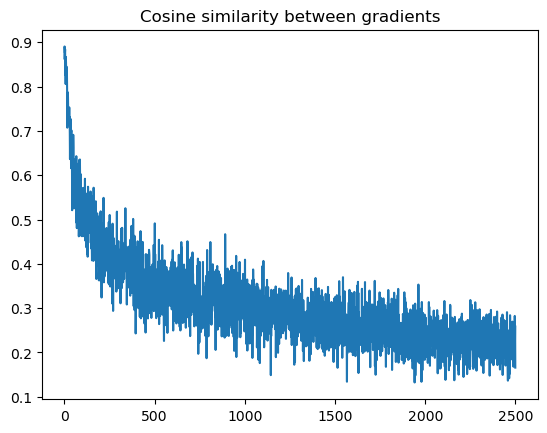

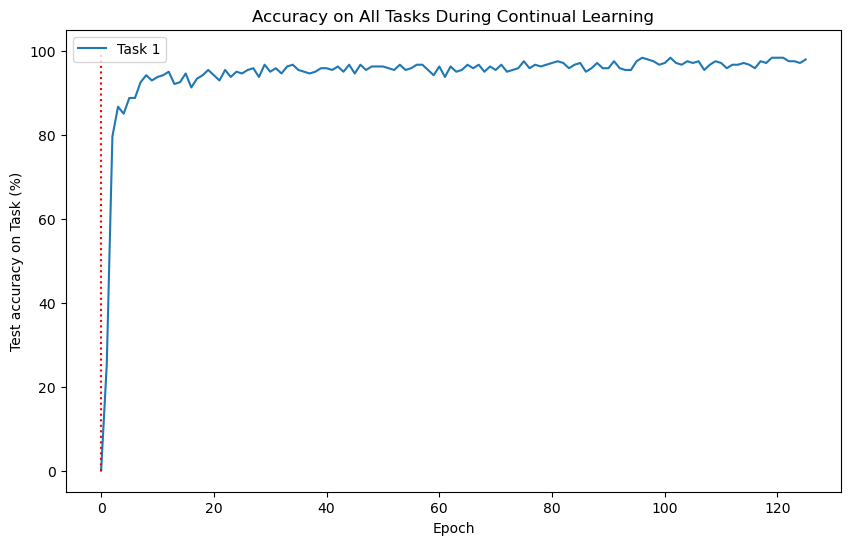

Epoch 1/1 - Loss: 0.2664  - Test accuracy: 95.42%:  58%|█████▊    | 1447/2500 [07:33<08:13,  2.13it/s]

In [7]:

num_rounds = 10  # Number of datasets to create and train on
num_epochs = 1  # Number of epochs to train on each dataset
all_accuracies = []

if torch.backends.mps.is_available():
    device = "mps"
else:
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# device='cpu'    

model = MLP(input_dim=784, output_dim=10, num_features=100000, n_layers=2)  # Initialize the model
model = model.to(device)
init_model = copy.deepcopy(model)
model = perturb_model(model, 1e-3)
log_posteriors = {name: torch.zeros_like(p) for name, p in model.named_parameters()}
# reinitialize_with_sign(model, magnitude=1e-3)

# # model = perturb_model_bernoulli(model, 1e-3)

eval_interval = 20

for r in range(num_rounds):
    train_loader, test_loader = shuffled_MNIST(24)  # Create new shuffled dataset
    # Update all test loaders to include the new test set
    if r == 0:
        all_test_loaders = [test_loader]
        # start on a good foot
    else:
        all_test_loaders.append(test_loader)

    # Train the model and evaluate on all datasets
    accuracies, cosines = train_and_evaluate_NTKBayes(model, log_posteriors, train_loader, all_test_loaders, num_epochs, device, 
                                             init_model, temperature=1e-6,
                                             test_batches=10)

    # make a histogram of the log posteriors
    plot_posteriors(log_posteriors)
    all_accuracies.append(accuracies)
    plt.plot(cosines)
    plt.title("Cosine similarity between gradients")
    plt.show()
    plot_accuracies(all_accuracies, num_epochs, r+1, eval_interval, train_loader)

Epoch 1/1 - Loss: 2.2641  - Test accuracy: 13.33%: 100%|██████████| 2500/2500 [09:55<00:00,  4.19it/s]


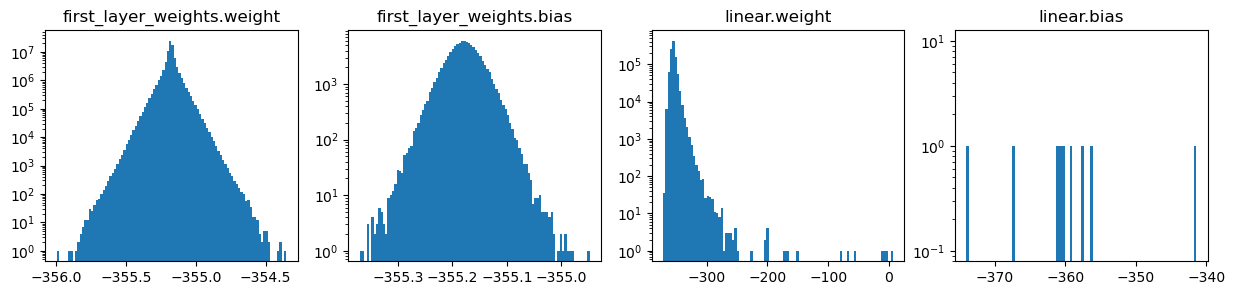

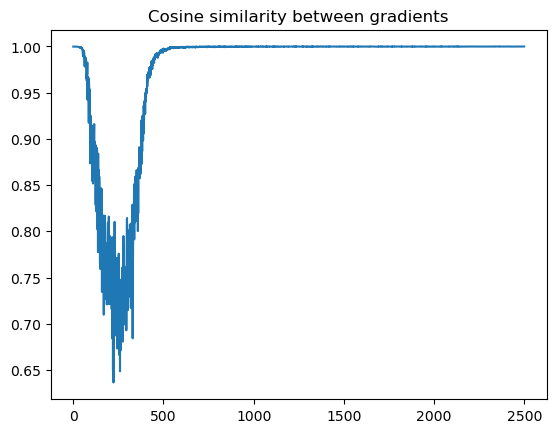

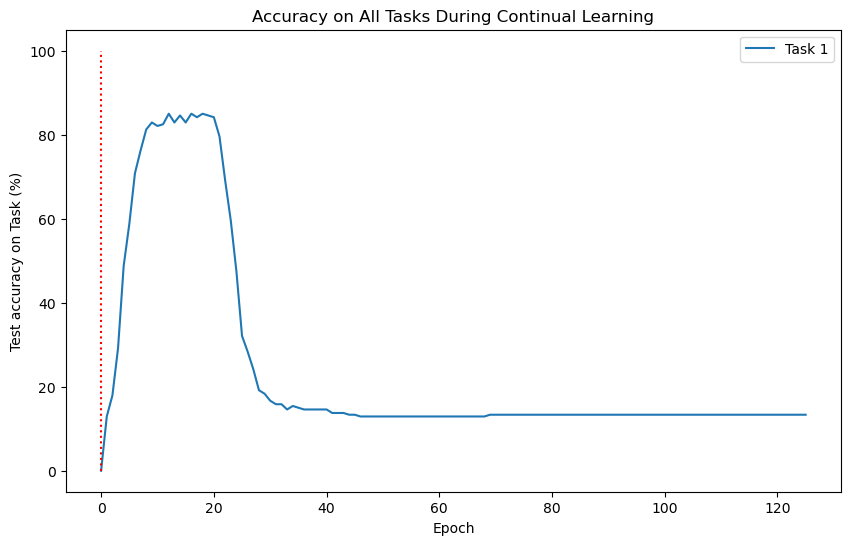

Epoch 1/1 - Loss: 2.2804  - Test accuracy: 4.58%:  54%|█████▍    | 1358/2500 [05:27<04:33,  4.18it/s]

In [7]:

num_rounds = 10  # Number of datasets to create and train on
num_epochs = 1  # Number of epochs to train on each dataset
all_accuracies = []

if torch.backends.mps.is_available():
    device = "mps"
else:
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# device='cpu'    

model = MLP(input_dim=784, output_dim=10, num_features=100000, n_layers=2)  # Initialize the model
model = model.to(device)
init_model = copy.deepcopy(model)
model = perturb_model(model, 1e-5)
log_posteriors = {name: torch.zeros_like(p) for name, p in model.named_parameters()}
# reinitialize_with_sign(model, magnitude=1e-3)

# # model = perturb_model_bernoulli(model, 1e-3)

eval_interval = 20

for r in range(num_rounds):
    train_loader, test_loader = shuffled_MNIST(24)  # Create new shuffled dataset
    # Update all test loaders to include the new test set
    if r == 0:
        all_test_loaders = [test_loader]
        # start on a good foot
    else:
        all_test_loaders.append(test_loader)

    # Train the model and evaluate on all datasets
    accuracies, cosines = train_and_evaluate_NTKBayes(model, log_posteriors, train_loader, all_test_loaders, num_epochs, device, init_model, temperature=1e-4, prune_cutoff=1e-2,
                                             test_batches=10)

    # make a histogram of the log posteriors
    plot_posteriors(log_posteriors)
    all_accuracies.append(accuracies)
    plt.plot(cosines)
    plt.title("Cosine similarity between gradients")
    plt.show()
    plot_accuracies(all_accuracies, num_epochs, r+1, eval_interval, train_loader)

The naive algorithm clearly improves until the gradient correlation goes down.

Epoch 1/1 - Loss: 2.3328  - Test accuracy: 9.69%: 100%|██████████| 1875/1875 [07:10<00:00,  4.36it/s] 


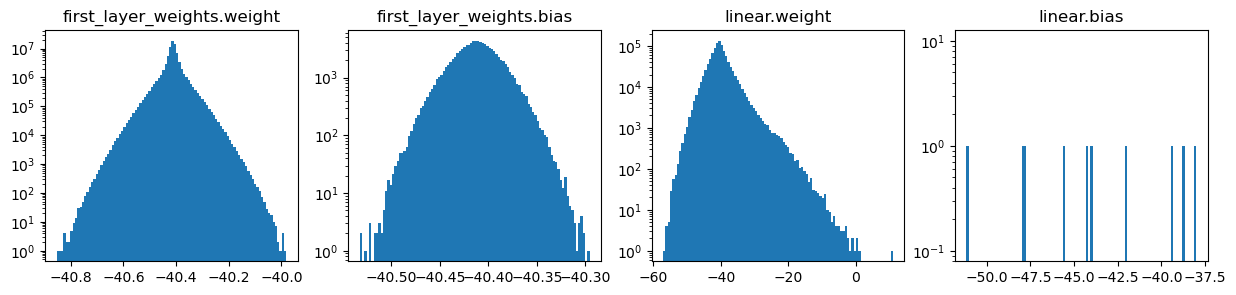

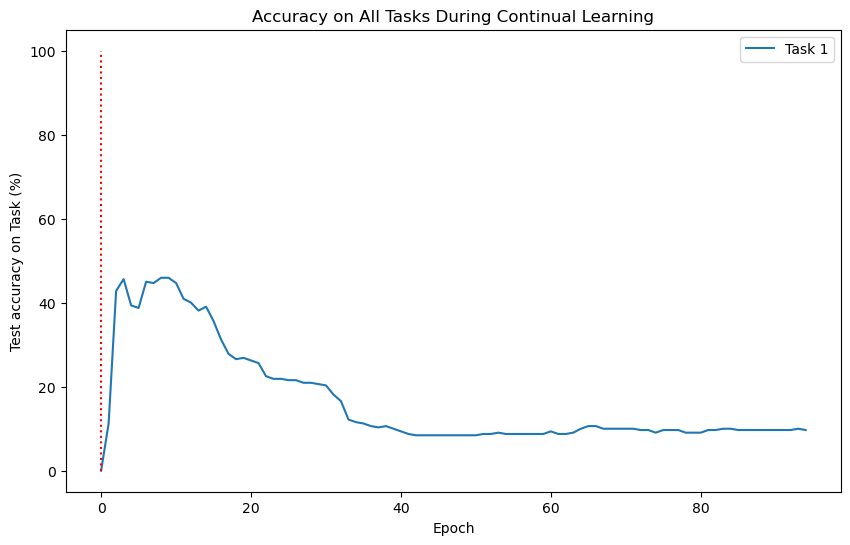

Epoch 1/1 - Loss: 2.3660  - Test accuracy: 9.06%:  16%|█▌        | 304/1875 [01:10<06:04,  4.31it/s]


KeyboardInterrupt: 

In [7]:

num_rounds = 10  # Number of datasets to create and train on
num_epochs = 1  # Number of epochs to train on each dataset
all_accuracies = []

if torch.backends.mps.is_available():
    device = "mps"
else:
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# device='cpu'    

model = MLP(input_dim=784, output_dim=10, num_features=100000, n_layers=2)  # Initialize the model
model = model.to(device)
init_model = copy.deepcopy(model)
model = perturb_model(model, 1e-3)
log_posteriors = {name: torch.zeros_like(p) for name, p in model.named_parameters()}
# reinitialize_with_sign(model, magnitude=1e-3)

# # model = perturb_model_bernoulli(model, 1e-3)

eval_interval = 20

for r in range(num_rounds):
    train_loader, test_loader = shuffled_MNIST(32)  # Create new shuffled dataset
    # Update all test loaders to include the new test set
    if r == 0:
        all_test_loaders = [test_loader]
        # start on a good foot
    else:
        all_test_loaders.append(test_loader)

    # Train the model and evaluate on all datasets
    accuracies = train_and_evaluate_NTKBayes(model, log_posteriors, train_loader, all_test_loaders, num_epochs, device, init_model, temperature=1e-7,
                                             test_batches=10)

    # make a histogram of the log posteriors
    plot_posteriors(log_posteriors)
    all_accuracies.append(accuracies)
    
    plot_accuracies(all_accuracies, num_epochs, r+1, eval_interval, train_loader)

Altogether it's clear what's happening. The init version works so long as the gradients are still reasonably related. But if the network moves too far, this is not the case.

We either need a way to keep the network close. (Setting a max parameter size is one way).

Or we need to use versions of expansions that are more accurate. But I fear using the current gradients will always lead to forgetting, as the ensembling theory only works when the function is the same.

In [1]:

def train_and_evaluate_NTKBayes(model, log_posterior_buffer, train_loader, test_loaders, num_epochs, device, init_model=None, 
                    temperature=1, prune_cutoff=0, epsilon=1e-9, test_batches = 10, max_log_posterior = 1e6, weight_penalty=1):
    """
    Trains and evaluates a given model as a neural tangent ensemble.

    This optimizer interprets the magnitude of each ∆W of (params - init_params) as a probability - or indeed, as a weight – upon its respective neural tangent kernel (NTK) feature. 
    
    The goal is to build an ensemble where p(y|x) = \sum_i p(y|x, W_i) p(W_i|x), where W_i are the weights of the ith model in the ensemble.
    
    Each edge contributes a perturbation to the init model: p(y|x, W_i) = p(y|x, W(0)) + grad p(y|x, W(0))
                                                                        = p(y|x, W(0))(1 + grad log p(y|x, W(0)))
    
    Each iteratation, as new data is seen, the posterior probability of this tangent model is updated by:
        1. Computing the new data likelihood as prod_j p(y_j|x_j, W(0))(1 + grad_w_i log p(y_j|x_j, W(0)))
                                                = prod_i exp(-loss_j) (1 + grad_w_i loss_j)
        2. Multiplying ∆W with this data likelihood
        3. Normalizing all ∆W to sum to 1 (thus estimating the posterior probability)
    The weights W are then adjusted with the computed ∆W.


    Parameters:
    - model (torch.nn.Module): The neural network model to be trained and evaluated.
    - train_loader (torch.utils.data.DataLoader): The DataLoader for training data.
    - test_loaders (list[torch.utils.data.DataLoader]): A list of DataLoaders for evaluation data.
    - optimizer (torch.optim.Optimizer): The optimizer to use for updating model weights.
    - num_epochs (int): The number of epochs to train the model.
    - device (torch.device): The device to run the training on (e.g., 'cuda' or 'cpu').

    Returns:
    - dict: A dictionary where each key is the index of the test loader in `test_loaders` and each value is a list of accuracies recorded at the end of each epoch.

    The function outputs progress logs directly to the console using tqdm, which shows a progress bar for the training iterations and logs the accuracy for each test set after every epoch.
    """
    all_accuracies = {i: [] for i in range(len(test_loaders))}  # Dictionary to store accuracies

    loss_fn = nn.CrossEntropyLoss()

    def compute_loss(params, buffers, sample, target):
        batch = sample.unsqueeze(0)
        targets = target.unsqueeze(0)

        predictions = torch.func.functional_call(model, (params, buffers), (batch,))
        loss = loss_fn(predictions, targets)
        return loss

    ft_compute_grad = torch.func.grad_and_value(compute_loss)
    ft_compute_sample_grad = torch.func.vmap(ft_compute_grad, in_dims=(None, None, 0, 0))
    ft_compute_losses = torch.func.vmap(compute_loss, in_dims=(None, None, 0, 0))

    if init_model is None:
        raise #Waiting to implement the zero init case
        init_model_params = {name: 0 for name, p in model.named_parameters()}
        init_model_buffers = {name: 0 for name, p in model.named_buffers()}
    else:
        init_model_params = {k: v.detach() for k, v in init_model.named_parameters()}
        init_model_buffers = {k: v.detach() for k, v in init_model.named_buffers()}

    z = sum([(p-p_c).abs().sum() for ((_, p), (_, p_c)) in zip( model.named_parameters(), init_model_params.items())])
    log_z = torch.log(z)

    frac_parameters = torch.Tensor([p.numel() for (_,p) in model.named_parameters()]).to(device)
    frac_parameters /= frac_parameters.sum()


    batch_count = 0
    accuracy = 0
    cosine_grads = []
    for epoch in range(num_epochs):
        model.train()
        with tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs}") as t:
            for batch, (data, target) in enumerate(t):
                data, target = data.to(device), target.to(device)  # Move data to the appropriate device

                params = {k: v.detach() for k, v in model.named_parameters()}
                buffers = {k: v.detach() for k, v in model.named_buffers()}

                per_example_grad_dict_init, losses_init = ft_compute_sample_grad( init_model_params, init_model_buffers, data, target)
                per_example_grad_dict, losses = ft_compute_sample_grad( params, buffers, data, target)

                # cosine of angle between gradients
                cosines = []
                for (name, d_p), (name2, p) in zip(per_example_grad_dict.items(), per_example_grad_dict_init.items()):
                    cosine = (d_p * p).sum() / (d_p.norm() * p.norm())
                    cosines.append(cosine)
                cosine_grads.append((torch.stack(cosines) @ frac_parameters).item())

                with torch.no_grad():
                    for (name, d_p), (name2, p), (name3, p_c), (_,log_posterior) in zip(per_example_grad_dict_init.items(), 
                                                                                model.named_parameters(),
                                                                                init_model_params.items(),
                                                                                log_posteriors.items()):
                        if not p.requires_grad:
                            continue

                        if init_model is None:
                            # If init_params is None, use the current gradients divided by 2 for linearization
                            delta_p = p.data
                            d_p = d_p / 2
                        else:
                            # Compute ∆W and use it as the weight for NTK features
                            delta_p = p.data - p_c.data

                        # store sign of weight
                        sign_delta_p = torch.sign(delta_p)

                        n_dims = len(delta_p.size())

                        arg = -sign_delta_p[None] * d_p * z * temperature
                        assert torch.all(arg+1 >= 0), f"Tried log(1+{torch.min(arg).item()}) for {name}. Decrease temperature or ∆W. z is {z.item()}"
                        data_log_likelihood = -losses_init[(...,)+(None,)*n_dims]+ torch.log1p(arg)
                        data_log_likelihood = data_log_likelihood.sum(dim=0)
                    
                        # Update log(∆W) based on the gradient and temperature
                        log_posterior += data_log_likelihood

                        # Penalize large ∆W by including in the likelihood a term that is proportional to the magnitude of the weight
                        log_posterior -= weight_penalty * log_posterior


                    # Get the log partition function
                    log_z_prime = torch.logsumexp(torch.stack([torch.logsumexp(lp, dim=list(range(len(lp.size()))))
                                                             for (name, lp) in log_posteriors.items()]), dim=0)

                    # set parameters
                    for (name, log_posterior), (_, p), (_, p_c) in zip(log_posteriors.items(), model.named_parameters(), init_model_params.items()):
                        if not p.requires_grad:
                            continue

                        log_posterior += log_z - log_z_prime
                        sign_delta_p = torch.sign(p.data - p_c.data)

                        # Update the parameter.
                        if init_model is None:
                            raise #Waiting to implement the zero init case
                        else:
                            p.data = p_c.data + sign_delta_p * torch.exp(log_posterior)

                    if batch_count % eval_interval == 0:
                        model.eval()
                        for i, test_loader in enumerate(test_loaders):
                            correct = 0
                            total = 0
                            j = 0
                            for data, target in test_loader:
                                data, target = data.to(device), target.to(device)
                                output = model(data)
                                loss =  nn.CrossEntropyLoss()(output, target)
                                _, predicted = torch.max(output.data, 1)
                                total += target.size(0)
                                correct += (predicted == target).sum().item()
                                j += 1
                                if j >= test_batches:
                                    break
                            accuracy = 100 * correct / total
                            all_accuracies[i].append(accuracy)
                        model.train()

                    batch_count += 1

                max_log_posterior = max([torch.max(lp).item() for lp in log_posteriors.values()])
                t.set_description(f"""Epoch {epoch+1}/{num_epochs} - Loss: {losses.mean().item():.4f}  - Test accuracy: {accuracy:.2f}% Max log posterior {max_log_posterior:.2f}  -  Cosine grad  {cosine_grads[-1]:.4f}""") #t.set_description
                
    return all_accuracies, cosine_grads

def perturb_model(model, noise_scale):
    for p in model.parameters():
        p.data += torch.randn_like(p.data) * noise_scale
    return model

def perturb_model_bernoulli(model, noise_scale):
    for p in model.parameters():
        p.data += torch.sign(torch.randn_like(p.data)) * noise_scale
    return model


In [2]:

num_rounds = 10  # Number of datasets to create and train on
num_epochs = 1  # Number of epochs to train on each dataset
all_accuracies = []

if torch.backends.mps.is_available():
    device = "mps"
else:
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# device='cpu'    

model = MLP(input_dim=784, output_dim=10, num_features=100000, n_layers=2)  # Initialize the model
model = model.to(device)
init_model = copy.deepcopy(model)
model = perturb_model(model, 1e-3)
log_posteriors = {name: torch.zeros_like(p) for name, p in model.named_parameters()}
# reinitialize_with_sign(model, magnitude=1e-3)

# # model = perturb_model_bernoulli(model, 1e-3)

eval_interval = 20

for r in range(num_rounds):
    train_loader, test_loader = shuffled_MNIST(24)  # Create new shuffled dataset
    # Update all test loaders to include the new test set
    if r == 0:
        all_test_loaders = [test_loader]
        # start on a good foot
    else:
        all_test_loaders.append(test_loader)

    # Train the model and evaluate on all datasets
    accuracies = train_and_evaluate_NTKBayes(model, log_posteriors, train_loader, all_test_loaders, num_epochs, device, init_model, temperature=1e-7,
                                             test_batches=10, max_log_posterior=-7)

    # make a histogram of the log posteriors
    plot_posteriors(log_posteriors)
    all_accuracies.append(accuracies)
    
    plot_accuracies(all_accuracies, num_epochs, r+1, eval_interval, train_loader)

NameError: name 'torch' is not defined